In [ ]:
import environments
import lsp
import numpy as np
import pytest
import matplotlib.pyplot as plt


def _get_env_and_args():
    parser = lsp.utils.command_line.get_parser()
    args = parser.parse_args(['--save_dir', ''])
    args.current_seed = 2034
    args.map_type = 'office2'
    args.step_size = 1.8
    args.num_primitives = 16
    args.field_of_view_deg = 360
    args.base_resolution = 1.0
    args.inflation_radius_m = 2.5
    args.laser_max_range_m = 120
    args.num_range = 32
    args.num_bearing = 128
    args.network_file = None

    # Create the map
    known_map, map_data, pose, goal = environments.generate.map_and_poses(args)
    return known_map, map_data, pose, goal, args


def run_planning_loop(known_map, map_data, pose, goal, args, unity_path,
                      planner, num_steps=None, do_plan_with_naive=False, do_yield_planner=False):
    # Initialize the world and builder objects
    world = environments.simulated.OccupancyGridWorld(
        known_map,
        map_data,
        num_breadcrumb_elements=args.num_breadcrumb_elements)
    builder = environments.simulated.WorldBuildingUnityBridge
    robot = lsp.robot.Turtlebot_Robot(pose,
                                      primitive_length=args.step_size,
                                      num_primitives=args.num_primitives,
                                      map_data=map_data)

    with builder(unity_path) as unity_bridge:
        unity_bridge.make_world(world)

        simulator = lsp.simulators.Simulator(known_map,
                                             goal,
                                             args,
                                             unity_bridge=unity_bridge,
                                             world=world)
        simulator.frontier_grouping_inflation_radius = (
            simulator.inflation_radius)

        planning_loop = lsp.planners.PlanningLoop(goal,
                                                  known_map,
                                                  simulator,
                                                  unity_bridge,
                                                  robot,
                                                  args,
                                                  verbose=True)

        steps = 0
        for counter, step_data in enumerate(planning_loop):
            print('hi')
            # Update the planner objects
            planner.update(
                {'image': step_data['image']},
                step_data['robot_grid'],
                step_data['subgoals'],
                step_data['robot_pose'],
                step_data['visibility_mask'])

            if counter % 5 == 0:
                fig, axs = plt.subplots(1, 2, figsize=(12, 6))
                robot_pose = step_data['robot_pose']
                # 1. Robot's camera/image view
                axs[0].imshow(step_data['image'])
                axs[0].set_title("Robot Camera View")
                axs[0].axis('off')
                
                planned_path = step_data.get('planned_path', None)
                
                # 2. Maze/map view using plot_navigation_data
                lsp.utils.plotting.plot_navigation_data(
                    axs[1],
                    step_data['robot_grid'],
                    known_map,
                    map_data=map_data,
                    robot_pose=step_data['robot_pose'],
                    goal_pose=goal,
                    planned_path=planned_path
                    # visibility_mask=step_data.get('visibility_mask', None),
                )
                axs[1].set_title("Maze Map View")

                # Plot robot path (actual traversed)
                # if robot_path:
                #     path_x, path_y = zip(*robot_path)
                #     axs[1].plot(path_y, path_x, 'r-', label='Robot Path', linewidth=2)

                # Plot and label subgoals
                subgoals = step_data.get('subgoals', [])
                for subgoal in subgoals:
                    print(subgoal.points)
                    for i in range(len(subgoal.points[0])):
                        # axs[1].plot(subgoal.points[0][i], subgoal.points[1][i], 'bx')
                        axs[1].text(subgoal.points[0][i], subgoal.points[1][i], f'SG{i}', color='red', fontsize=1)

                # Optionally, label the robot and goal
                # if hasattr(robot_pose, 'x') and hasattr(robot_pose, 'y'):
                #     axs[1].plot(robot_pose.y, robot_pose.x, 'ro')
                #     axs[1].text(robot_pose.y, robot_pose.x, 'Robot', color='red', fontsize=8)
                # if hasattr(goal, 'x') and hasattr(goal, 'y'):
                #     axs[1].plot(goal.y, goal.x, 'go')
                #     axs[1].text(goal.y, goal.x, 'Goal', color='green', fontsize=8)

                axs[1].legend()
                plt.tight_layout()
                plt.show()

            if do_yield_planner:
                yield planner

            if planner is not None and not do_plan_with_naive:
                planning_loop.set_chosen_subgoal(planner.compute_selected_subgoal())
            steps += 1

        print(f'Total Steps: {steps}')

            # if num_steps is not None and counter >= num_steps:
            #     break

def test_lsp_plan_loop_base_no_subgoals(do_debug_plot, unity_path):
    """Confirm that planning with "no subgoals" does not crash."""
    known_map, map_data, pose, goal, args = _get_env_and_args()
    planner = lsp.planners.DijkstraPlanner(goal=goal, args=args)
    run_planning_loop(known_map, map_data, pose, goal, args, unity_path,
                      planner, num_steps=20, do_plan_with_naive=True)


def test_lsp_plan_loop_base_dijkstra(do_debug_plot, unity_path):
    """Confirm that planning with the Dijkstra planner does not crash."""
    known_map, map_data, pose, goal, args = _get_env_and_args()
    planner = lsp.planners.DijkstraPlanner(goal=goal, args=args)
    run_planning_loop(known_map, map_data, pose, goal, args, unity_path,
                      planner, num_steps=20, do_plan_with_naive=True)


def test_lsp_plan_loop_known_sets_subgoal_nn_inputs(do_debug_plot, unity_path):
    """Confirm that planning with the Dijkstra planner succeeds."""
    known_map, map_data, pose, goal, args = _get_env_and_args()
    planner = lsp.planners.KnownSubgoalPlanner(goal=goal, known_map=known_map,
                                               args=args, verbose=True,
                                               do_compute_weightings=False)
    for planner in run_planning_loop(known_map, map_data, pose, goal, args,
                                     unity_path, planner, num_steps=20,
                                     do_plan_with_naive=True,
                                     do_yield_planner=True):
        continue
    #     assert planner.subgoals
    #     assert all(subgoal.props_set for subgoal in planner.subgoals)
    #     assert all(hasattr(subgoal, 'nn_input_data') for subgoal in planner.subgoals)

    #     are_new_subgoals = any([subgoal.just_set for subgoal in planner.subgoals])
    #     are_old_subgoals = any([not subgoal.just_set for subgoal in planner.subgoals])

    #     if are_new_subgoals and not are_old_subgoals:
    #         # If there are only new subgoals, confirm that the images are the same
    #         total_pixel_values = [subgoal.nn_input_data['image'].sum()
    #                               for subgoal in planner.subgoals]
    #         assert np.std(total_pixel_values) == pytest.approx(0)
    #     elif are_new_subgoals and are_old_subgoals:
    #         # If there are both new and old subgoals, confirm that the images are different
    #         total_pixel_values = [subgoal.nn_input_data['image'].sum()
    #                               for subgoal in planner.subgoals]
    #         assert np.std(total_pixel_values) > 0
    #         for subgoal in planner.subgoals:
    #             assert (subgoal.positive_weighting > 1 or subgoal.negative_weighting > 1)
    #         # break

    # assert len(planner.subgoals) > 0

def test_lsp_plan_loop_unknown_sets_subgoal_nn_inputs(do_debug_plot, unity_path):
    """Confirm that planning with the Dijkstra planner succeeds."""
    known_map, map_data, pose, goal, args = _get_env_and_args()
    planner = lsp.planners.BaseSubgoalPlanner(goal=goal, known_map=known_map,
                                               args=args, verbose=True,
                                               do_compute_weightings=False)
    for planner in run_planning_loop(known_map, map_data, pose, goal, args,
                                     unity_path, planner, num_steps=20,
                                     do_plan_with_naive=True,
                                     do_yield_planner=True):
        continue

In [15]:
known_map, map_data, pose, goal, args = _get_env_and_args()
knownSubgoalPlanner = lsp.planners.KnownSubgoalPlanner(goal=goal, known_map=known_map,
                                               args=args, verbose=False,
                                               do_compute_weightings=False)
dijkstraPlanner = lsp.planners.DijkstraPlanner(goal=goal, args=args)
knownPlanner = lsp.planners.KnownPlanner(goal=goal, known_map=known_map, args=args)
unity_path = '/unity/rail_sim.x86_64'

Goal: 267, 292
Robot: 100, 90 [motion: 0]
Counter: 0 | Count since last turnaround: 100
Computing Image
  image time: 11.473894596099854
hi
[[ 98  98  97  98  97  97  96  97]
 [ 97  98  99  99 100 101 102 102]]
[[106 107 107 108 108 109]
 [ 96  96  97  97  98  98]]
[[120 120 121 122 123 124]
 [ 94  95  95  95  95  95]]


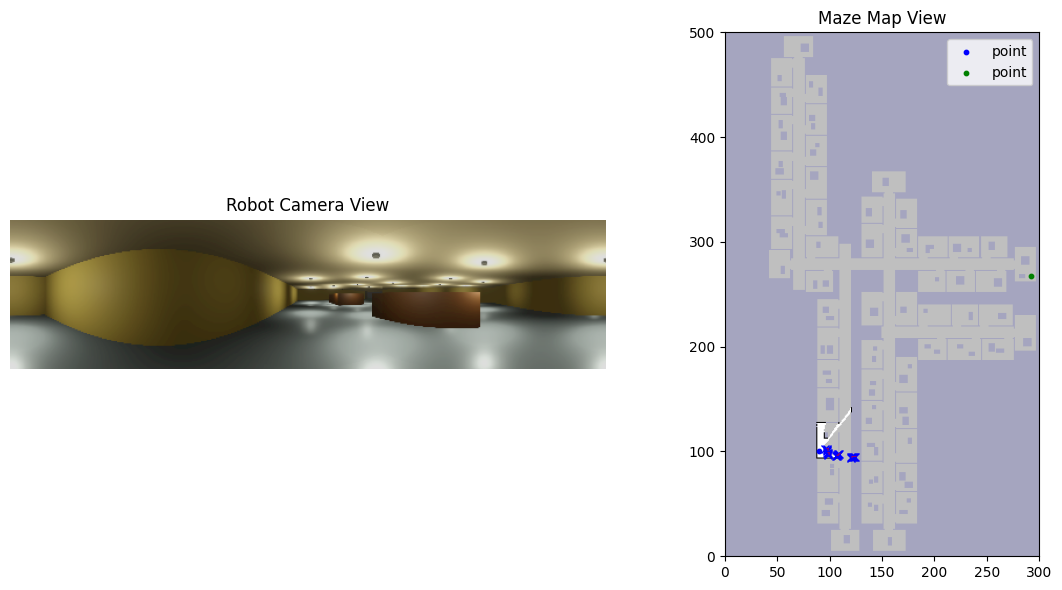

Planning via subgoal masking.
[[100 102 103 104 105 106 107 107 107 107 107 116 117 118 119 120 121 122
  123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
  141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
  159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
  177 178 179 180 181 182 183 184 185 186 187 188 188 188 188 188 188 188
  188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188
  188 188 188 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
  203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
  221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
  239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256
  257 258 259 260 261 262 263 264 264 264 264 265 266 267]
 [ 90  91  91  91  91  92  93  94  95  96  97 110 111 112 113 114 115 116
  117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
  135 136 137 138 139 1

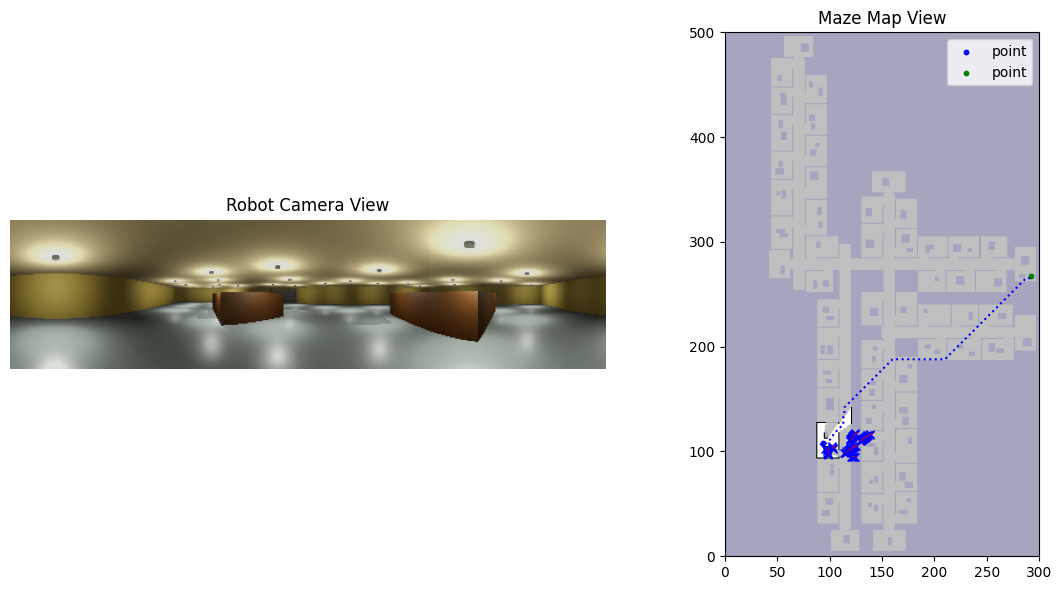

Planning via subgoal masking.
[[107 108 108 108 109 110 111 112 113 117 118 119 120 121 122 123 124 125
  126 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
  146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
  164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
  182 183 184 185 186 187 188 188 188 188 188 188 188 188 188 188 188 188
  188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188
  188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188
  188 188 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
  204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
  222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
  240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
  258 259 260 261 262 263 264 264 264 264 265 266 267]
 [ 93  95  96  97  98  99 100 101 102 104 105 106 107 108 109 110 111 112
  113 113 113 113 113 113 1

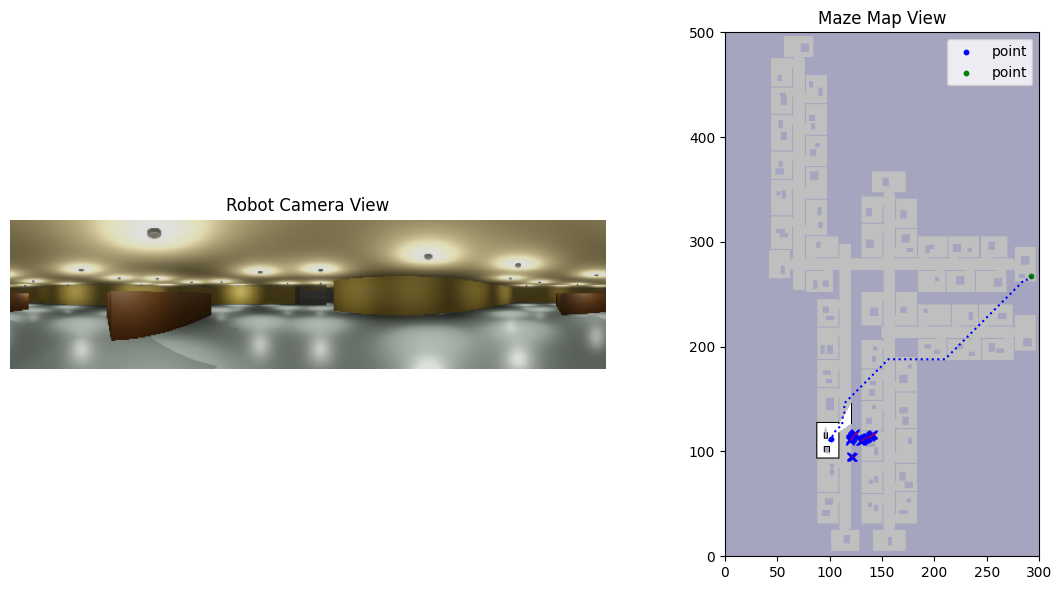

Planning via subgoal masking.
[[111 113 118 119 120 121 122 123 124 125 126 127 128 129 130 136 137 138
  139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
  157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
  175 176 177 178 179 180 181 182 183 184 185 186 187 188 188 188 188 188
  188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188
  188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188
  188 188 188 188 188 188 188 188 188 188 188 188 188 188 189 190 191 192
  193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
  211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
  229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
  247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
  264 264 264 265 266 267]
 [100 102 104 105 106 107 108 109 110 111 112 112 112 112 112 114 114 114
  114 114 114 114 114 114 114 114 115 116 117 118 119 1

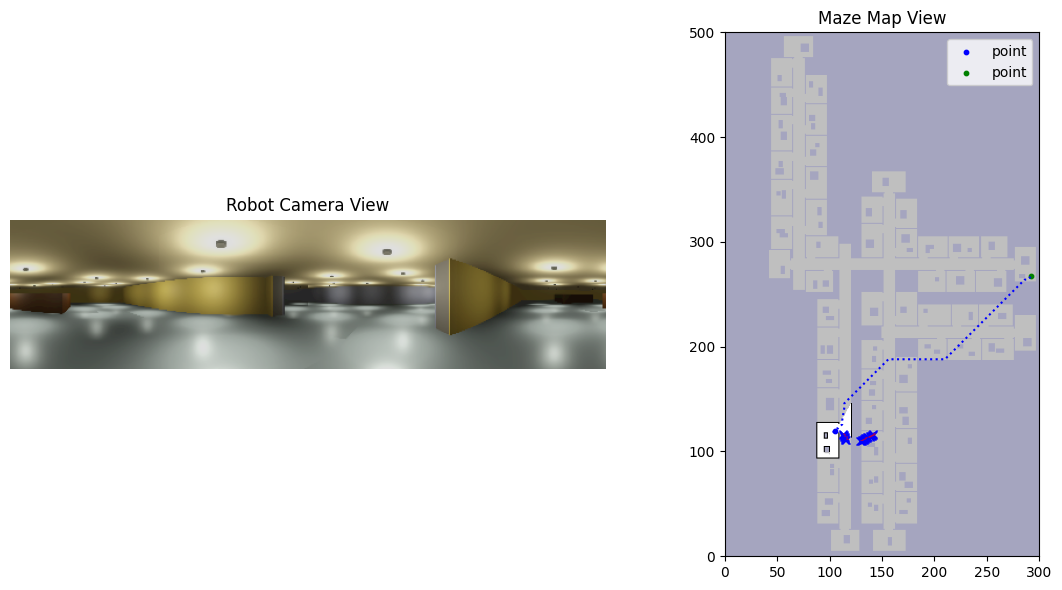

Planning via subgoal masking.
[[119 121 122 123 124 125 126 127 128 129 130 144 145 146 147 148 149 150
  151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
  169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
  187 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188
  188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188
  188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188 188
  188 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
  205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
  223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
  241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
  259 260 261 262 263 264 264 264 264 265 266 267]
 [105 107 108 109 110 111 112 112 112 112 112 114 114 114 115 116 117 118
  119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
  137 138 139 140 141 142 143 1

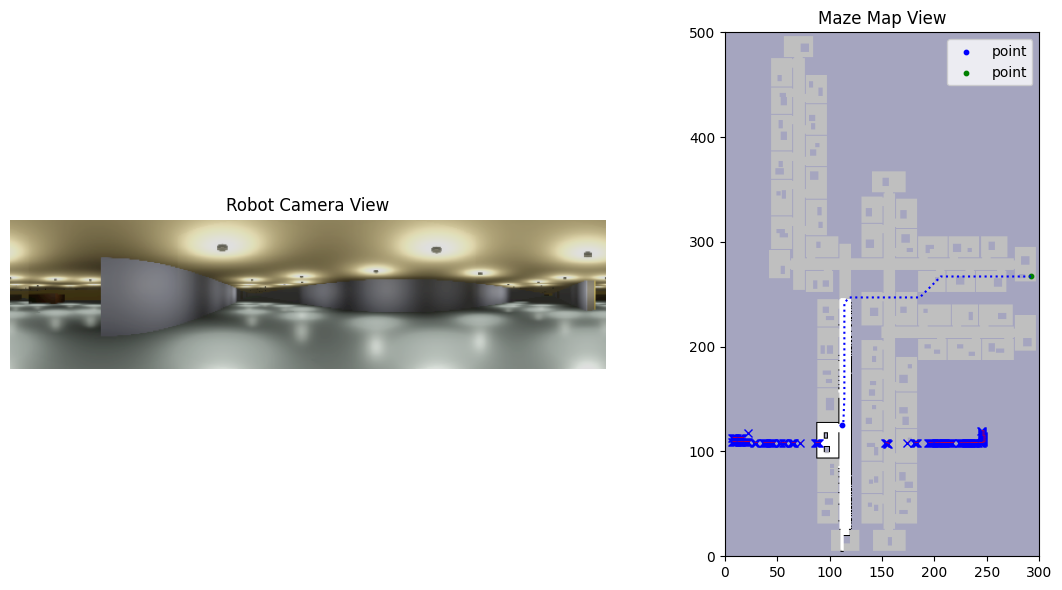

Planning via subgoal masking.
[[125 127 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
  166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
  184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
  202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
  220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
  238 239 240 241 242 243 244 245 246 247 247 247 247 247 247 247 247 247
  247 247 247 247 247 247 247 247 247 247 247 247 247 247 247 247 247 247
  247 247 247 247 247 247 247 247 247 247 247 247 247 247 247 247 247 247
  247 247 247 247 247 247 247 247 247 247 247 247 247 247 247 247 247 247
  247 247 247 247 247 248 249 250 251 252 253 254 255 256 257 258 259 260
  261 262 263 264 265 266 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 26

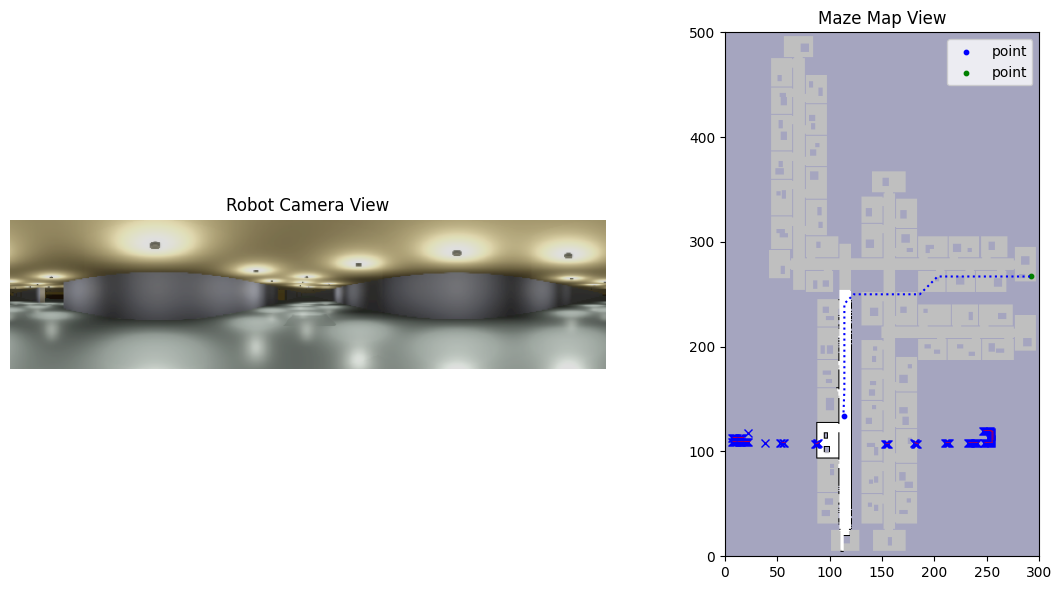

Planning via subgoal masking.
[[133 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
  175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
  193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
  211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
  229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
  247 248 249 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250
  250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250
  250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250
  250 250 250 250 250 250 250 250 250 250 250 250 250 251 252 253 254 255
  256 257 258 259 260 261 262 263 264 265 266 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 26

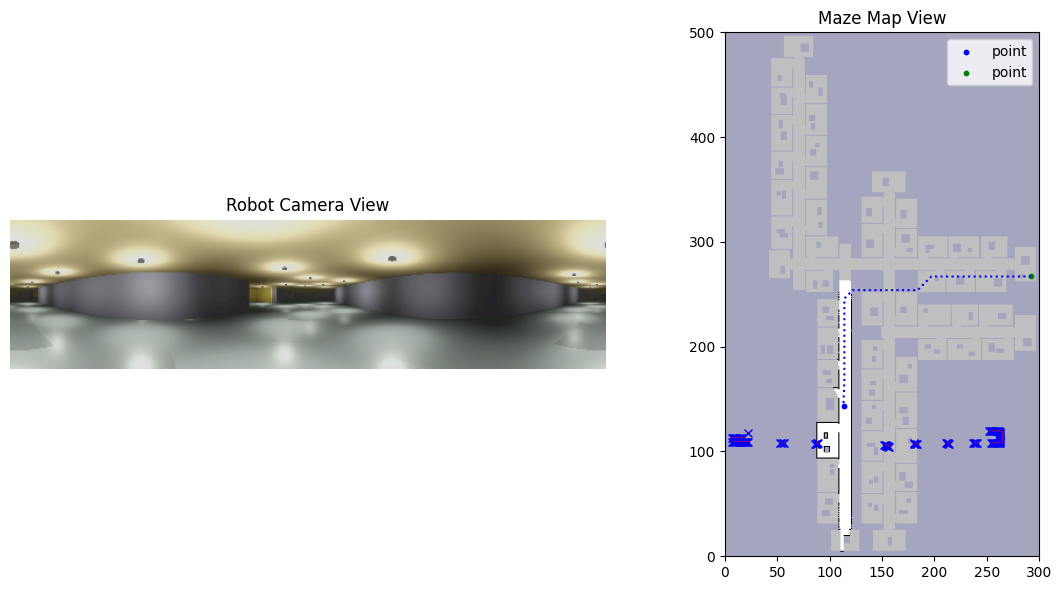

Planning via subgoal masking.
[[142 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
  184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
  202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
  220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
  238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
  255 255 255 255 255 255 256 257 258 259 260 261 262 263 264 265 266 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 26

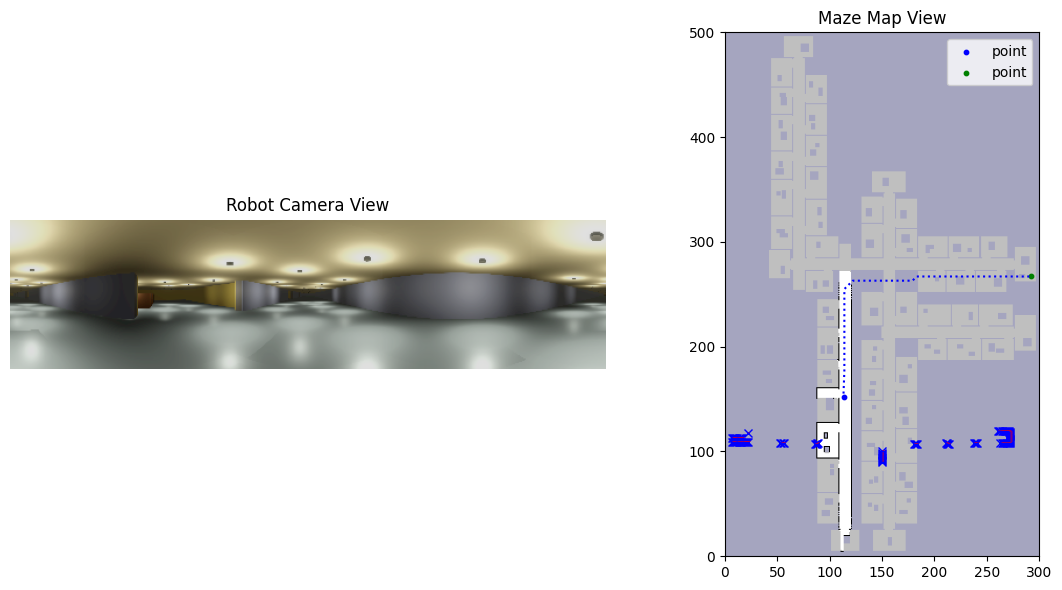

Planning via subgoal masking.
[[151 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
  193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
  211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
  229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
  247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
  265 266 266 266 266 266 266 266 266 266 266 266 266 266 266 266 266 266
  266 266 266 266 266 266 266 266 266 266 266 266 266 266 266 266 266 266
  266 266 266 266 266 266 266 266 266 266 266 266 266 266 266 266 266 266
  266 266 266 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 26

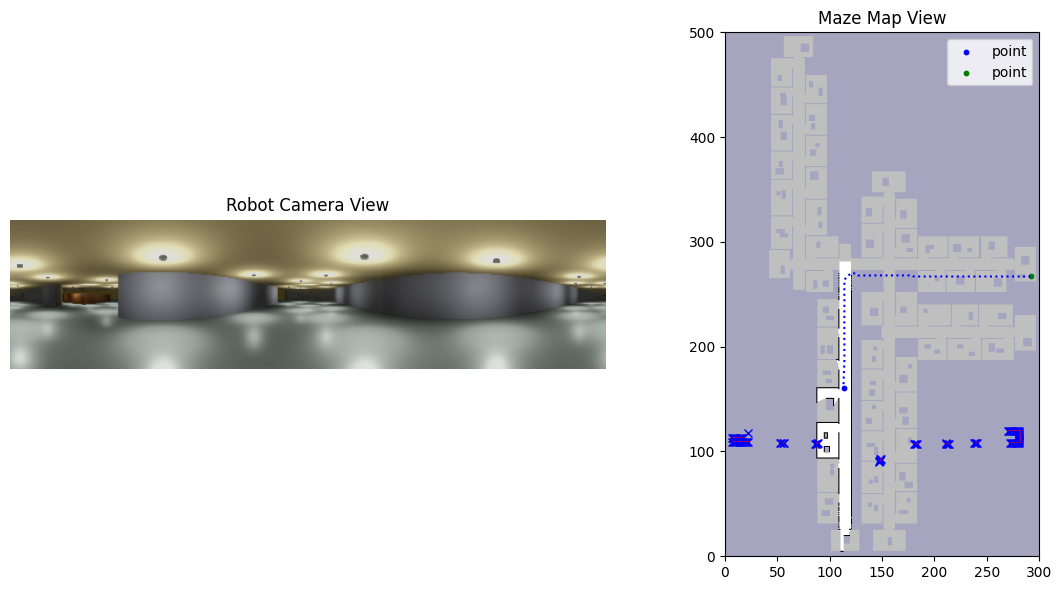

Planning via subgoal masking.
[[160 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
  202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
  220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
  238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
  256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 271 271
  271 271 271 271 271 271 271 271 271 271 271 271 271 271 271 271 271 271
  271 271 271 271 271 271 271 271 271 271 271 271 271 271 271 271 271 271
  271 271 271 271 271 271 271 271 271 271 271 271 271 271 271 271 271 271
  271 271 271 270 269 268 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 26

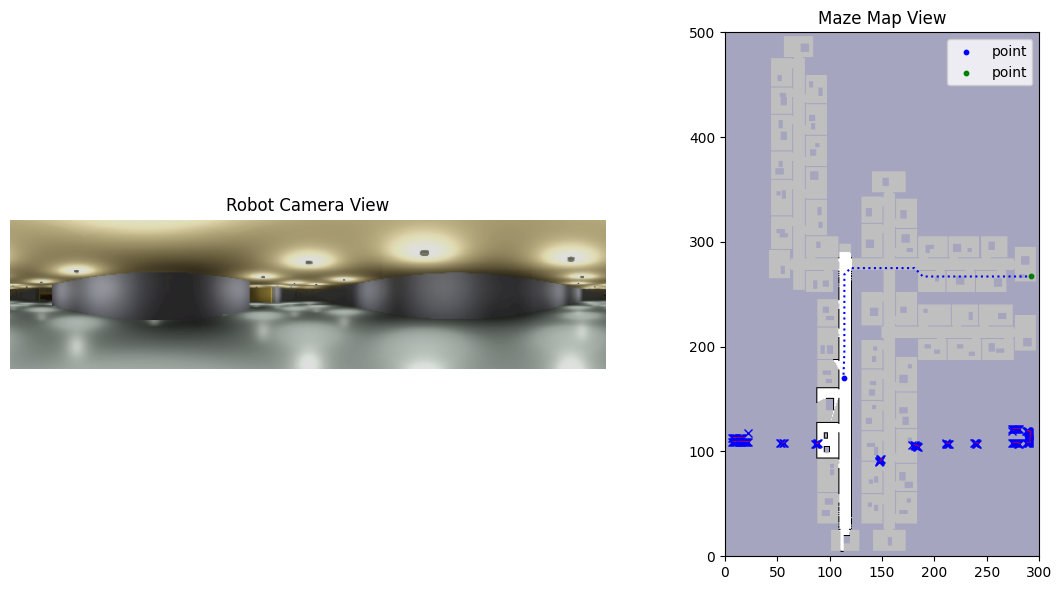

Planning via subgoal masking.
[[169 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
  211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
  229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
  247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
  265 266 267 268 269 270 271 272 273 274 275 275 275 275 275 275 275 275
  275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275
  275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275
  275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275
  274 273 272 271 270 269 268 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 26

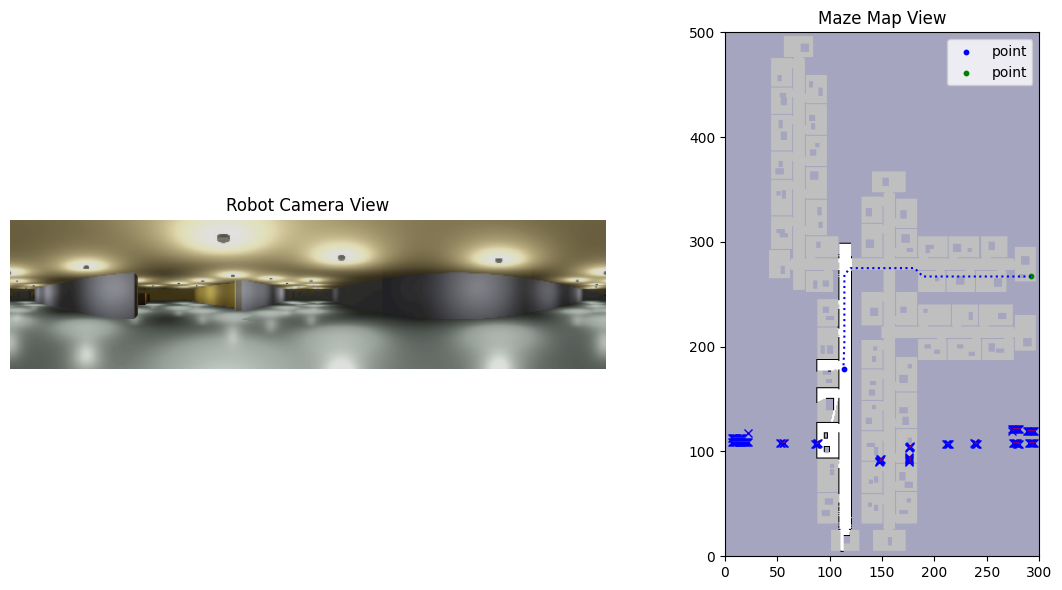

Planning via subgoal masking.
[[178 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
  220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
  238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
  256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
  274 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275
  275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275
  275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275
  275 275 275 275 275 275 275 275 275 274 273 272 271 270 269 268 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 26

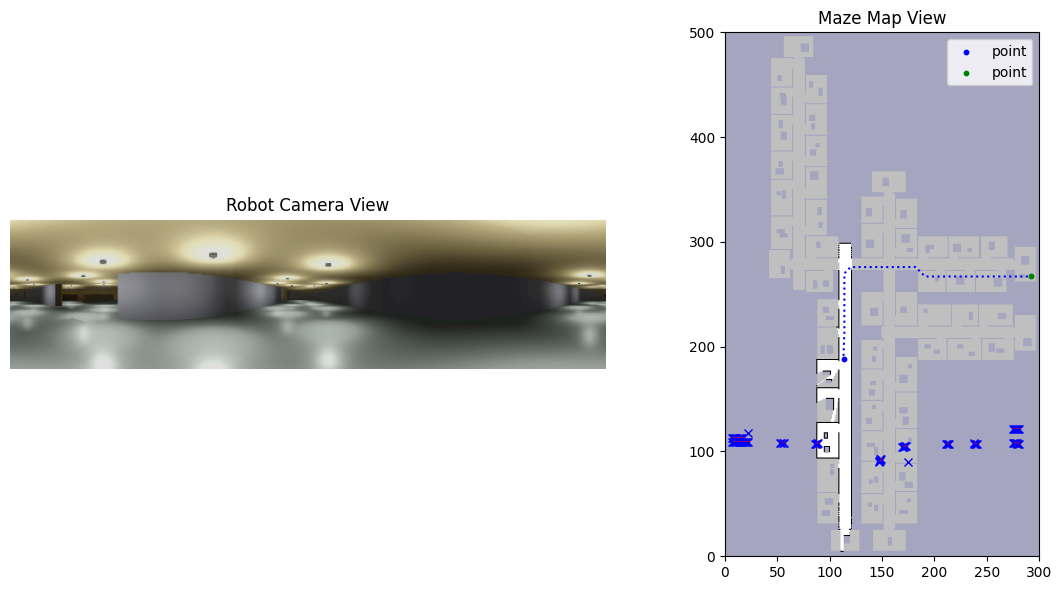

Planning via subgoal masking.
[[187 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
  229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
  247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
  265 266 267 268 269 270 271 272 273 274 275 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 275 274 273 272 271 270 269 268 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 26

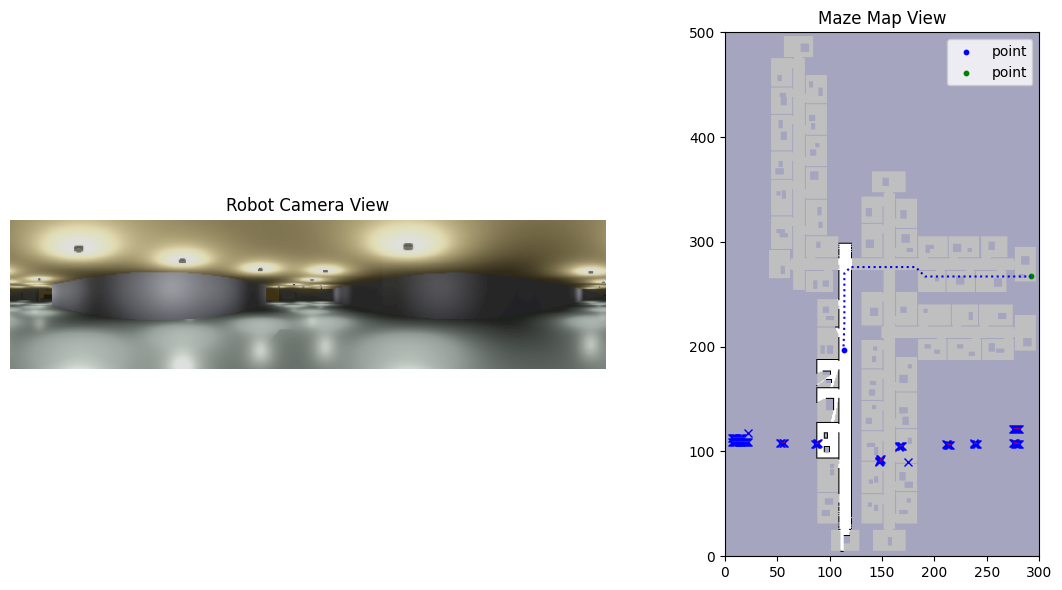

Planning via subgoal masking.
[[196 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
  238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
  256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
  274 275 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 275 274 273 272 271 270 269
  268 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267]
 [113 114 114 114 114 114 1

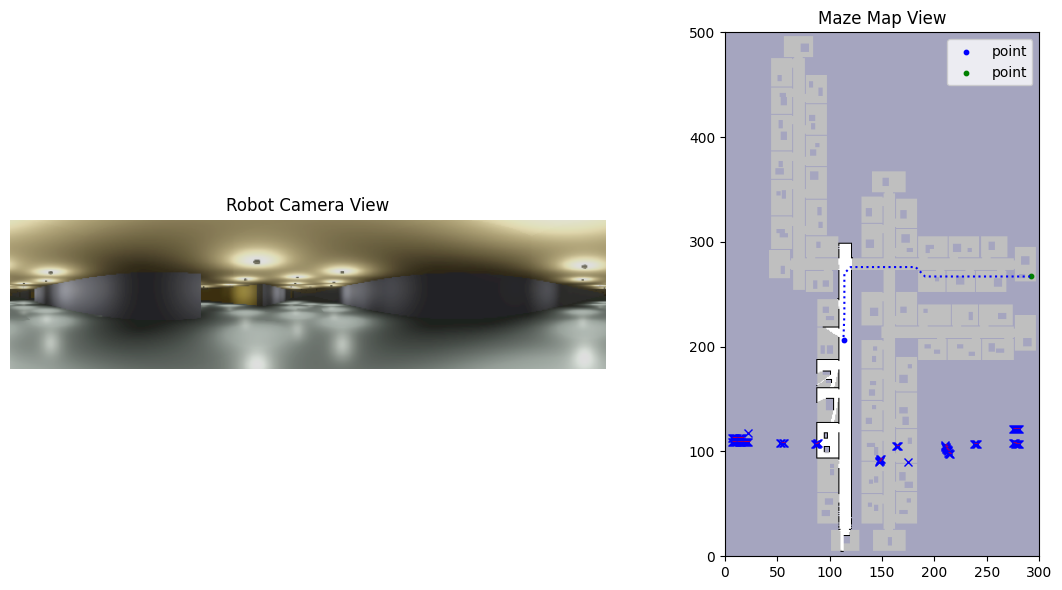

Planning via subgoal masking.
[[205 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
  247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
  265 266 267 268 269 270 271 272 273 274 275 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 275 274 273 272 271 270 269 268 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267]
 [113 114 114 114 114 114 114 114 114 114 114 114 114 114 114 1

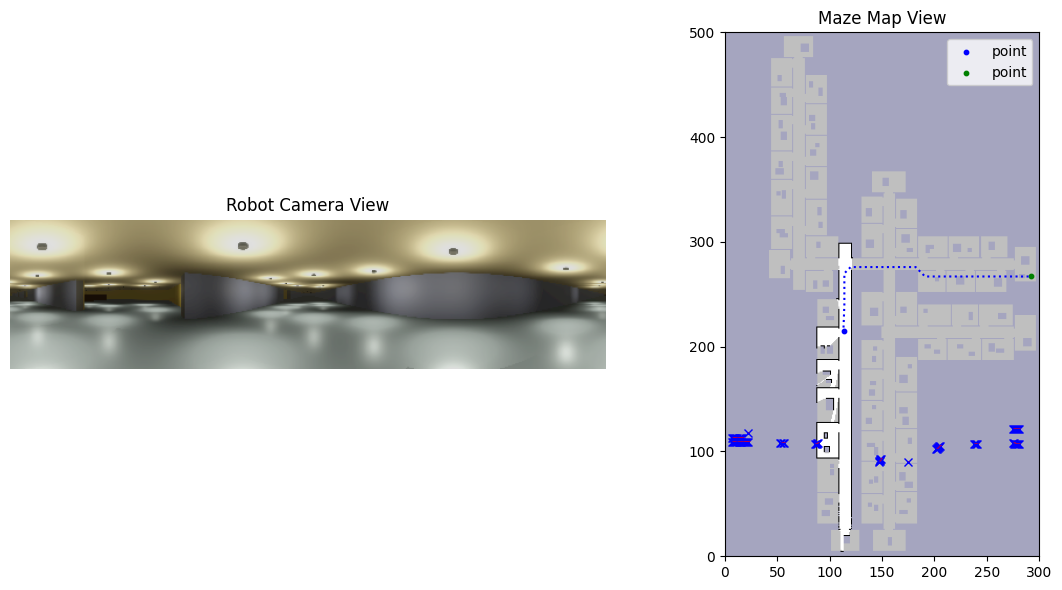

Planning via subgoal masking.
[[214 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
  256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
  274 275 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 275 274 273 272 271 270 269
  268 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267]
 [113 114 114 114 114 114 114 114 114 114 114 114 114 114 114 114 114 114
  114 114 114 114 114 114 1

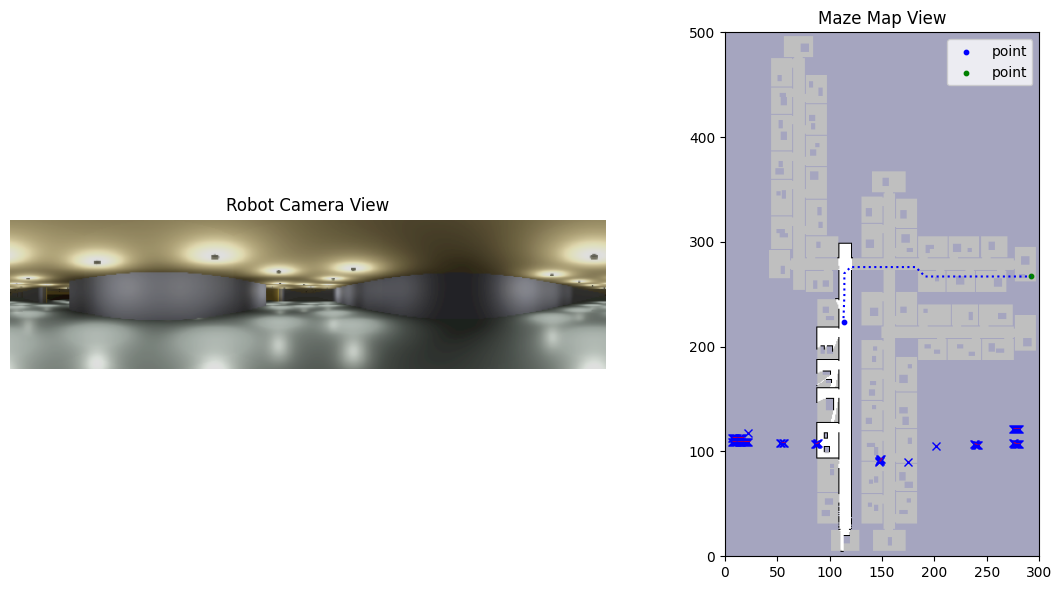

Planning via subgoal masking.
[[223 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
  265 266 267 268 269 270 271 272 273 274 275 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 275 274 273 272 271 270 269 268 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267]
 [113 114 114 114 114 114 114 114 114 114 114 114 114 114 114 114 114 114
  114 114 114 114 114 114 115 116 117 118 119 120 121 122 123 1

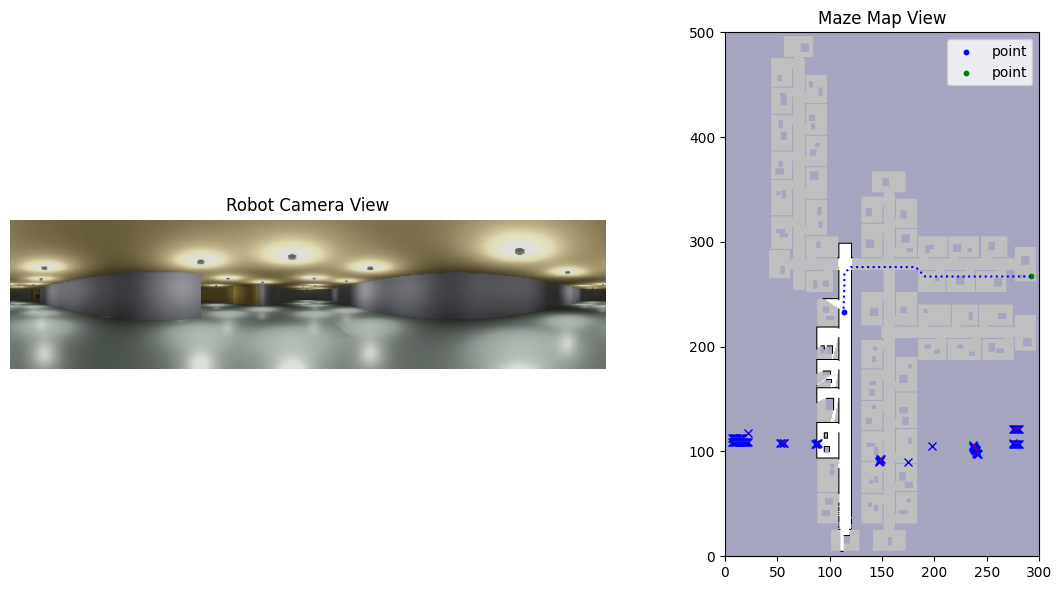

Planning via subgoal masking.
[[232 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
  274 275 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 275 274 273 272 271 270 269
  268 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267]
 [113 114 114 114 114 114 114 114 114 114 114 114 114 114 114 115 116 117
  118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
  136 137 138 139 140 141 1

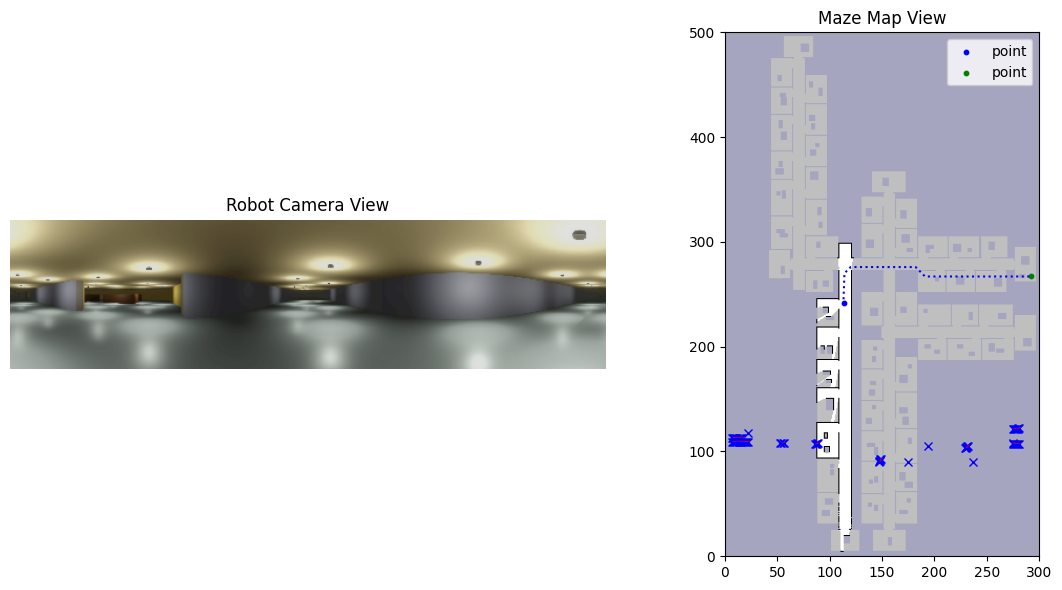

Planning via subgoal masking.
[[241 266 267 268 269 270 271 272 273 274 275 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 275 274 273 272 271 270 269 268 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267]
 [113 114 114 114 114 114 115 116 117 118 119 120 121 122 123 124 125 126
  127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
  145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 1

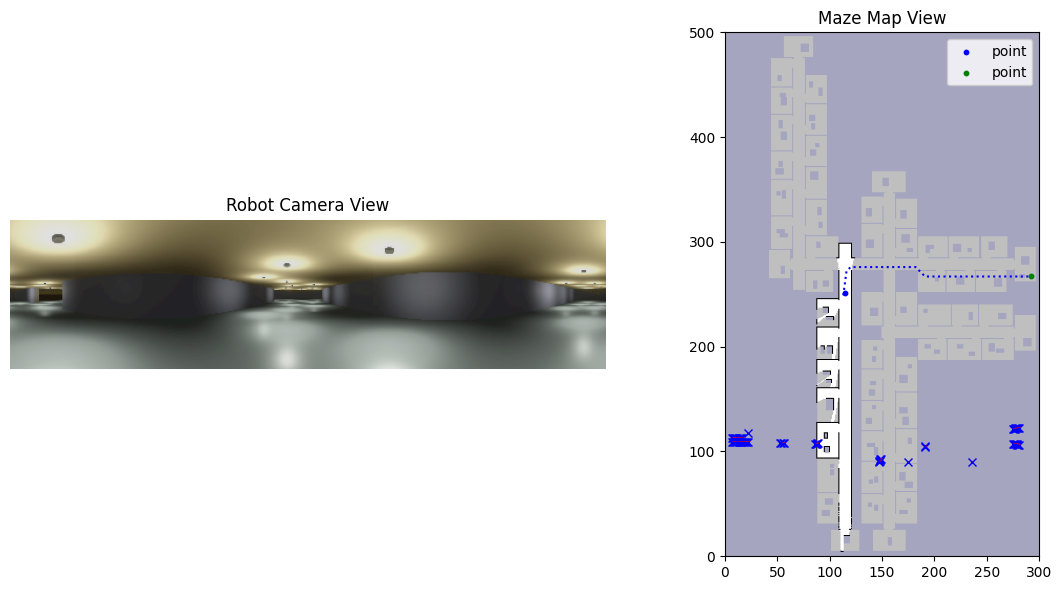

Planning via subgoal masking.
[[250 272 273 274 275 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 275 274 273 272
  271 270 269 268 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267]
 [114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
  133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
  151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
  169 170 171 1

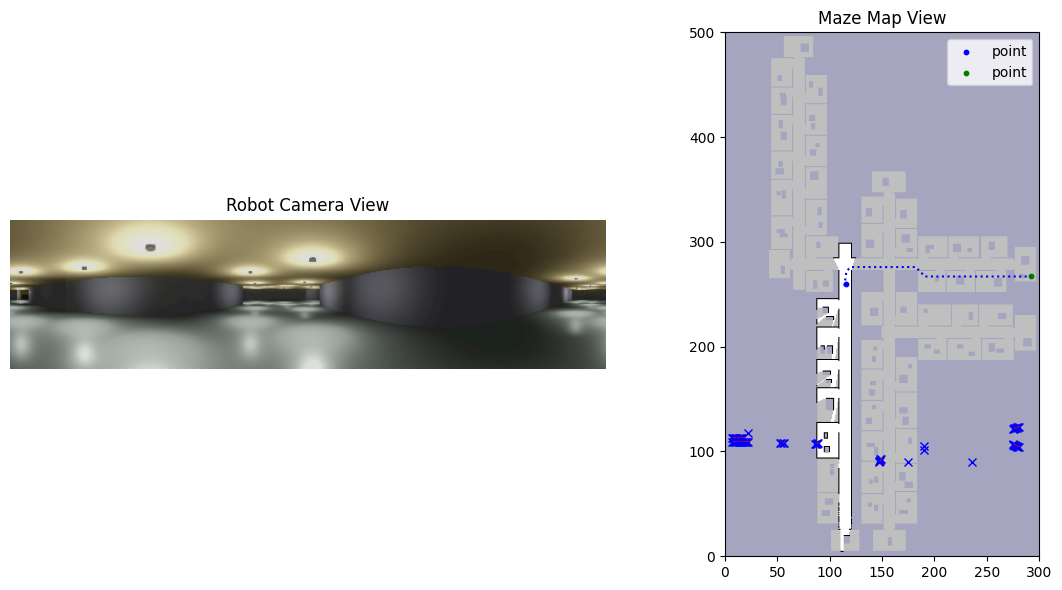

Planning via subgoal masking.
[[259 272 273 274 275 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276 276
  276 276 276 276 276 276 276 276 275 274 273 272 271 270 269 268 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267]
 [115 116 117 118 119 120 121 128 129 130 131 132 133 134 135 136 137 138
  139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
  157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174
  175 176 177 178 179 180 181 182 183 1

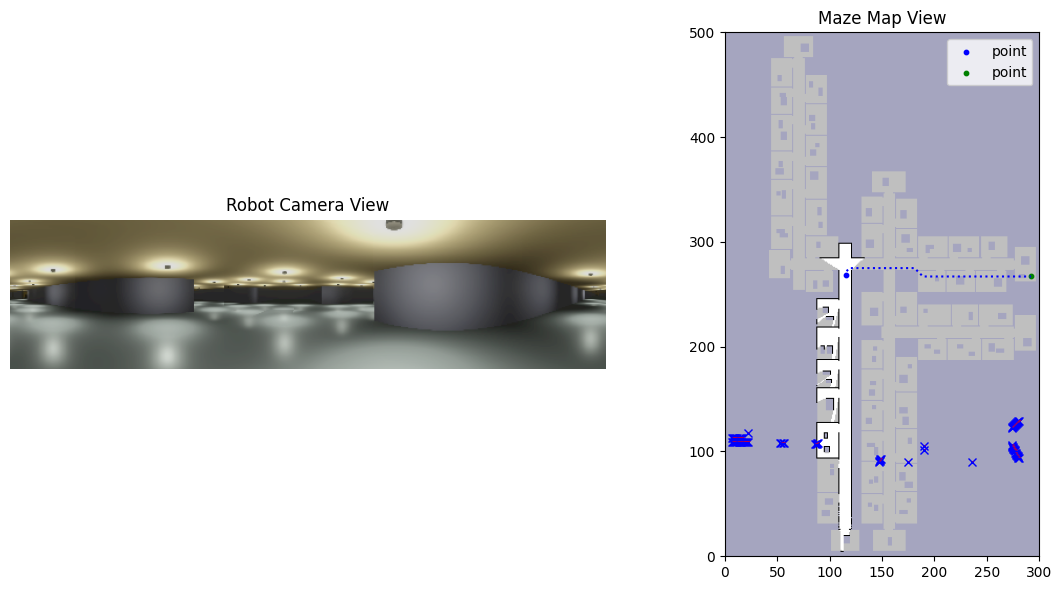

Planning via subgoal masking.
[[268 272 273 274 275 275 275 275 275 275 275 275 275 275 275 275 275 275
  275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275
  275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275 275
  274 273 272 271 270 269 268 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267]
 [115 116 117 118 119 120 121 122 123 137 138 139 140 141 142 143 144 145
  146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
  164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
  182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 1

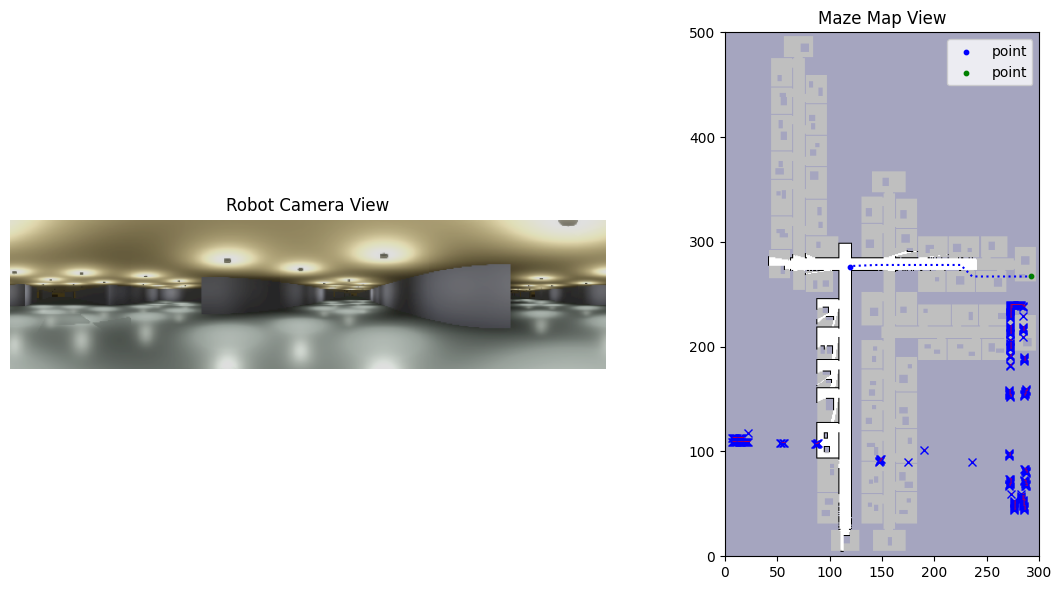

Planning via subgoal masking.
[[276 278 278 278 278 278 278 278 278 278 278 278 278 278 278 278 278 278
  278 278 278 278 278 278 278 278 278 278 278 278 278 278 278 278 278 278
  278 278 278 278 278 278 278 278 278 278 278 278 278 278 278 278 278 278
  278 278 278 278 278 278 278 278 278 278 278 278 278 278 278 278 278 278
  278 278 278 278 278 278 278 278 278 278 278 278 277 276 275 274 273 272
  271 270 269 268 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267 267
  267 267 267 267 267 267 267]
 [119 121 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
  160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
  178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
  196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
  214 215 216 217 218 219 220 221 222 223 224 225 2

error: unpack requires a buffer of 4 bytes

In [31]:
for planner in run_planning_loop(known_map, map_data, pose, goal, args,
                                     unity_path, knownSubgoalPlanner, num_steps=20,
                                     do_plan_with_naive=False,
                                     do_yield_planner=True):
        continue

In [ ]:
for planner in run_planning_loop(known_map, map_data, pose, goal, args,
                                     unity_path, dijkstraPlanner, num_steps=20,
                                     do_plan_with_naive=False,
                                     do_yield_planner=True):
        continue